In [2]:
import numpy as np
import os

DATA_DIR = "/var/ellie/data/mnist"

In [3]:
img_train = os.path.join(DATA_DIR, "train-images-idx3-ubyte.gz")
lbl_train = os.path.join(DATA_DIR, "train-labels-idx1-ubyte.gz")
img_test = os.path.join(DATA_DIR, "t10k-images-idx3-ubyte.gz")
lbl_test = os.path.join(DATA_DIR, "t10k-labels-idx1-ubyte.gz")

In [4]:
os.listdir(DATA_DIR)

['t10k-images-idx3-ubyte.gz',
 't10k-labels-idx1-ubyte.gz',
 'train-labels-idx1-ubyte.gz',
 'train-images-idx3-ubyte.gz']

In [5]:
import os
import gzip
import numpy as np
import tensorflow as tf

IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUM_TRAIN = 60000
NUM_TEST = 10000
IMAGE_SIZE = IMAGE_WIDTH * IMAGE_HEIGHT


def extract_data_as_nparrays(img_file, lbl_file, num_samples):
    """
    Extract data from imgs and labels zip files and return them as numpy arrays
    :param img_file: the full name of the zip file containing the images
    :param lbl_file: the full name of the zip file containing the labels
    :param num_samples: the number of examples to read from the files.
    :return: pair of numpy arrays containing image and label - both integers
    """
    with gzip.open(img_file) as bytestream:
        bytestream.read(16)

        buf = bytestream.read(IMAGE_SIZE * num_samples)
        imgs = np.frombuffer(buf, dtype=np.uint8)
        imgs = imgs.reshape(num_samples, IMAGE_HEIGHT, IMAGE_WIDTH, 1)

    with gzip.open(lbl_file) as bytestream:
        bytestream.read(8)

        buf = bytestream.read(num_samples)
        lbls = np.frombuffer(buf, dtype=np.uint8)

    return imgs, lbls


def dataset(data_dir, file_names, num_samples):
    (img_zip, lbl_zip) = file_names
    img_path = os.path.join(data_dir, img_zip)
    lbl_path = os.path.join(data_dir, lbl_zip)
    imgs, lbls = extract_data_as_nparrays(img_path, lbl_path, num_samples)
    img_tensor = tf.constant(imgs)
    img_tensor = tf.reshape(img_tensor, [num_samples, IMAGE_SIZE])
    lbl_tensor = tf.one_hot(tf.constant(lbls), depth=10)
    return tf.data.Dataset.from_tensor_slices((img_tensor, lbl_tensor))


def datasets(data_dir):
    """
    create a pair of datasets for train and test.
    The file names are expected to be the well-known types used by LeCun: USE-TYPE-TAG-ubyte.gz,
    where USE = 'train' or 't10k', TYPE='images' or 'labels' and 'TAG' = idx1 for labels and idx3 for images
    :param data_dir: the directory where the files are to be found
    :return: A pair of tf.data.Datasets containing raw integer tensors for images and one-hot-encoded labels
    """
    template = "%s-%s-ubyte.gz"

    def file_names(prefix):
        image_file = template % (prefix, "images-idx3")
        label_file = template % (prefix, "labels-idx1")
        return image_file, label_file

    train = dataset(data_dir, file_names("train"), NUM_TRAIN)
    test = dataset(data_dir, file_names("t10k"), NUM_TEST)
    return train, test


In [6]:
tr, te = datasets(DATA_DIR)

In [7]:
sess = tf.InteractiveSession()

In [8]:
trainer = tr.batch(20000).make_one_shot_iterator().get_next()

In [9]:
i,l = trainer

In [10]:
i

<tf.Tensor 'IteratorGetNext:0' shape=(?, 784) dtype=uint8>

In [11]:
i,l = sess.run([i,l])

In [12]:
i.shape

(20000, 784)

In [13]:
l.shape

(20000, 10)

In [15]:
import matplotlib.pyplot as plt
from math import log

#### Quick Refresher from information theory
Entropy 
$$ H(X) := -\sum_{x \in \mathcal{X}} p(x) \log p(x)$$

Conditional Entropy 
$$ H(Y \big| X) := \sum_{x \in \mathcal{X}} p(x) H(Y\big|X=x)$$

$$ = \sum_{x \in \mathcal{X}} p(x) \sum_{y\in \mathcal{Y}} p(y|x) * \log p(y|x)$$

$$ = \sum_{x \in \mathcal{X}} \sum_{y\in \mathcal{Y}} p(x,y) \log(\frac{p(x,y)}{p(x)})$$

Joint Entropy 
$$ H(Y, X) := -\sum_{x \in \mathcal{X}} \sum_{y\in \mathcal{Y}} p(x,y) \log p(x,y)$$

Mutual Information
$$ I(X;Y) := \sum_{x \in \mathcal{X}} \sum_{y\in \mathcal{Y}} p(x,y)log(\frac{p(x,y)}{p(x)p(y)}) $$

Observe: 
1. $H(X,Y) \leq H(X)+H(Y)$
1. $H(Y|X) = 0 \iff$ Y is completely determinded by X 
1. $H(Y|X) = H(Y) \iff $ X and Y are independent
1. $H(X|Y) = H(Y,X) - H(Y)$
1. $I(X;Y) = H(X) + H(Y) - H(X,Y)$

### Important note: Don't get confused!!
In the following you'll see X being used for the prior distribution that's the digit in case of MNIST and Y for the pixels. That is the opposite of what you know from any MNIST tutorial. The reason is that we're looking at the problem from an analytic view. We want to understand how the entropy of the result (the image) depends on the prior (the intended digit). It's actually the typical neural network that reverts the natural order by "guessing" what might have been meant by a certain image

##### Let's look at the distribution of a single pixel's values over a minibatch, subdivided into 10 arrays - one for each label:

In [14]:
# Pixel Nr. P
P = 300
pixels = i[:, P]
N_BINS=5
MIN_VAL=0
MAX_VAL=255
ln = np.argmax(l, axis=1)

In [15]:
# A list of lists: distributions of above pixel's values by digit
distr_by_digit=[list(map(lambda p: p[0], filter(lambda p: p[1]==digit, zip(pixels, ln)))) for digit in range(10)]

##### Let's see the pixel's distribution on various digits 

(array([1168.,  130.,  149.,   95.,  472.]),
 array([  0.,  51., 102., 153., 204., 255.]),
 <a list of 5 Patch objects>)

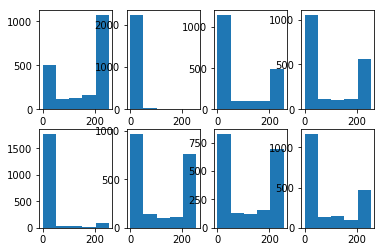

In [16]:
plt.subplot(2,4,1)
plt.hist(distr_by_digit[0], bins=N_BINS)
plt.subplot(2,4,2)
plt.hist(distr_by_digit[1], bins=N_BINS)
plt.subplot(2,4,3)
plt.hist(distr_by_digit[2], bins=N_BINS)
plt.subplot(2,4,4)
plt.hist(distr_by_digit[4], bins=N_BINS)
plt.subplot(2,4,5)
plt.hist(distr_by_digit[6], bins=N_BINS)
plt.subplot(2,4,6)
plt.hist(distr_by_digit[7], bins=N_BINS)
plt.subplot(2,4,7)
plt.hist(distr_by_digit[8], bins=N_BINS)
plt.subplot(2,4,8)
plt.hist(distr_by_digit[9], bins=N_BINS)

As expected, most of the pixels are either black or white with few in the grey areas. And the distributions obviously differ from digit to digit. If you look at pixel 200, you will see that it's basically always zero. Obviously, some pixels are helpful, others aren't.

To support statistics on the distribution we use a partitioning function that distributes the values into N_BINS

In [17]:
def partition(arr, width_bin, n_bins=N_BINS):

    # for each element of arr, which bin is to be incremented?
    arr = np.array(arr)//width_bin
    # Count the number of entries in each bin. I know, this is a tough algorithm. But it's cool.
    return np.sum(np.eye(n_bins)[arr], axis=0)

Let's verify by partitioning the pixel's distribution for all images of a 4. The top-right histogram above should match what we got here. 

In [18]:
partition(distr_by_digit[4], 255//N_BINS+1, N_BINS)

array([1054.,  114.,  108.,  116.,  553.])

Now let's define the entropy of an arbitary distribution. We do the statistics by distributing the values into N_BINS arrays.

In [19]:
def entropy(distr):
    res, _ = _entropy(distr)
    return res

def _entropy(distr):
    """
        calculate the entropy based on number counts in N_BINS
    """
    bins = partition(distr, MAX_VAL//N_BINS+1, N_BINS)
    N = sum(bins)
    return sum(map(lambda n_i: 0 if n_i == 0 else -n_i*log(n_i), bins))/N + log(N), N

Note that we used a little simplification here. Namely, with $ p(i) $ being the probability of finding the pixel's actual value in bin number $i$, $N$ being the total number of pixel values we estimate the probability $ p(i) = \frac{n_i}{N} $. The total number of pixel values is obviously the total number of images that are represented by the given distribution.

$$ -\sum_{i=1}^N p_i \log p_i = \frac{1}{N} \sum_{i=1}^N n_i \log(\frac{N}{n_i}) $$
$$ = \frac{1}{N} \sum_{i=1}^N n_i (\log N - \log n_i) = \log N - \frac{1}{N} \sum_{i=1}^N n_i \log n_i $$

You have certainly already figured out that the very last expression is exactly what's being calculated in the _entropy() function.

Let's see the entropies of the pixel's distribution for all 10 digits. Note that these are by definition the conditional entropies of the entire distribution, given a particular digit.

In [21]:
entropies = [entropy(distr_by_digit[digit]) for digit in range(10)]
total_entropy = entropy(pixels)
entropies, total_entropy

([1.2501706835152264,
  0.14041135145281736,
  1.1111259003476226,
  0.8610874162355433,
  1.1845274158832115,
  0.6401634041714823,
  0.43564978024483914,
  1.2194768231548814,
  1.2952208610437026,
  1.1745368269373042],
 1.0471564412739554)

Remember how we defined the conditional entropy $H(Y|X)$ of the total distribution? It's the probability-weighted sum of the particular entropies over the values of the prior X:

$$ H(Y \big| X) := \sum_{x \in \mathcal{X}} p(x) H(Y\big|X=x)$$

$$ = \sum_{x \in \mathcal{X}} p(x) \sum_{y\in \mathcal{Y}} p(y|x) * \log p(y|x)$$



Let's use this equation now to calculate the conditional image of a single pixel's distribution over a mini-batch of images

In [128]:
def particular_entropies(joint_distr):
    """
    calculate all particular conditional entropies
    :joint_distr a matrix of 10 x N_BINS bins counting the activations of a pixel 
    """
    res = []
    for x in range(3):
        nx = np.sum(joint_distr[x], axis=0)
        if nx != 0: 
            p_y_given_x = joint_distr[x] / nx
            p_y_given_x = list(filter(lambda p: p!=0, p_y_given_x))
            ent_x = -np.sum(p_y_given_x * np.log(p_y_given_x))
            res.append(ent_x)
    return res
    
def cond_entropy(pixels, labels):
    """
        calculate the conditional entropy of a pixel distribution in a mini-batch of images, 
        given the true labels.
    """
    X = labels
    Y = pixels
    X_probs = np.sum(np.eye(10)[X], axis=0) / len(X)
    
    by_digit=[list(map(lambda p: p[0], filter(lambda p: p[1]==digit, zip(Y, X)))) for digit in range(10)]

    bins =[partition(by_digit[digit], MAX_VAL//N_BINS+1, N_BINS) for digit in range(10)]

    entropies = particular_entropies(bins)
    
    zipped = zip(X_probs, entropies)
    return np.sum((list(map(lambda p_e: p_e[0]*p_e[1], zipped))))
    
    

In [129]:
cond_entropy(pixels, ln)

0.24782402486819016

Now let's compare the total entropy with the conditional one for a number of pixels. The higher the value the bigger the difference between total and conditional entropy. We expect to gain more information from those pixels. 

In [131]:
np.array([total_entropy - cond_entropy(i[:, P], ln) for P in range(200, 320)])

array([1.03600227, 1.01592042, 0.98950661, 0.95070805, 0.90072715,
       0.84401097, 0.80278449, 0.76478205, 0.72587492, 0.69718045,
       0.67561078, 0.66933729, 0.66443795, 0.67113842, 0.6863372 ,
       0.70684894, 0.74613159, 0.81295422, 0.88937311, 0.97087213,
       1.02723937, 1.04672656, 1.04715644, 1.04715644, 1.04715644,
       1.04715644, 1.04629833, 1.04550455, 1.03688991, 1.01367802,
       0.97910327, 0.9389746 , 0.88241123, 0.84046897, 0.80414952,
       0.78363095, 0.75070079, 0.7098232 , 0.67645065, 0.661323  ,
       0.65364245, 0.66003421, 0.68280642, 0.71056802, 0.76917738,
       0.80778815, 0.87310758, 0.95122203, 1.01914378, 1.04715644,
       1.04715644, 1.04715644, 1.04715644, 1.04671983, 1.04715644,
       1.04636933, 1.03778912, 1.01222646, 0.96958755, 0.91901731,
       0.87540023, 0.8376479 , 0.823951  , 0.81238047, 0.77594673,
       0.71833887, 0.68975978, 0.67582908, 0.66366379, 0.66063251,
       0.67667293, 0.72759988, 0.78485139, 0.82339799, 0.86703